In [2]:
import os, re, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

2025-11-28 04:33:52.847575: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 04:33:52.906187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 04:33:53.887238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10, 5)
sns.set(style="whitegrid")

# ====== 修改为你的 AudioWAV 路径 ======
AUDIO_DIR = "../AudioWAV"
AUDIO_DIR = Path(AUDIO_DIR)
assert AUDIO_DIR.exists(), f"路径不存在：{AUDIO_DIR}"

# 固定随机种子，结果更可复现
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [4]:
# CREMA-D 文件名格式： <speaker>_<sentence>_<emotion>_<intensity>.wav
# 例：1001_DFA_ANG_XX.wav
pat = re.compile(r"(?P<spk>\d{4})_(?P<sent>[A-Z]{3})_(?P<emo>[A-Z]{3})_(?P<inten>[A-Z]{2})\.wav$", re.I)

def parse_filename(p: Path):
    m = pat.search(p.name)
    if not m:
        return None
    gd = m.groupdict()
    return {
        "path": p,
        "speaker": int(gd["spk"]),
        "sentence": gd["sent"].upper(),
        "emotion": gd["emo"].upper(),
        "intensity": gd["inten"].upper(),
    }

files = sorted(AUDIO_DIR.glob("*.wav"))
rows = [parse_filename(p) for p in files]
meta = pd.DataFrame([r for r in rows if r is not None])

# 情绪与强度的映射/可读名
EMO_MAP = {"ANG":"Anger", "DIS":"Disgust", "FEA":"Fear", "HAP":"Happy", "NEU":"Neutral", "SAD":"Sad"}
INTEN_ORDER = ["LO","MD","HI","XX"]  # XX=未知
meta["emotion_name"] = meta["emotion"].map(EMO_MAP)
meta["intensity"] = pd.Categorical(meta["intensity"], categories=INTEN_ORDER, ordered=True)

meta.head()


,path,speaker,sentence,emotion,intensity,emotion_name
0,AudioWAV/1001_DFA_ANG_XX.wav,1001,DFA,ANG,XX,Anger
1,AudioWAV/1001_DFA_DIS_XX.wav,1001,DFA,DIS,XX,Disgust
2,AudioWAV/1001_DFA_FEA_XX.wav,1001,DFA,FEA,XX,Fear
3,AudioWAV/1001_DFA_HAP_XX.wav,1001,DFA,HAP,XX,Happy
4,AudioWAV/1001_DFA_NEU_XX.wav,1001,DFA,NEU,XX,Neutral


In [5]:
# 放在 import tensorflow as tf 之后、构建模型之前
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("启用 GPU 显存按需分配")
    except RuntimeError as e:
        print(e)


启用 GPU 显存按需分配


In [6]:
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# =====================
# 配置参数
# =====================
SAMPLE_RATE = 16000  # 16kHz 采样率
DURATION = 3.0       # 统一截取/填充到 3 秒
N_MELS = 80          # Mel 频段数 (对应频率维度)
Target_Length = int(DURATION * SAMPLE_RATE) # 目标采样点数

def extract_melspectrogram(path):
    # 1. 读取音频
    # str(path) 是因为 librosa 有时对 Path 对象支持不好
    y, sr = librosa.load(str(path), sr=SAMPLE_RATE)
    
    # 2. 统一长度 (Padding 或 Truncating)
    if len(y) < Target_Length:
        # 如果短了，补零
        y = np.pad(y, (0, Target_Length - len(y)))
    else:
        # 如果长了，截断
        y = y[:Target_Length]
        
    # 3. 计算 Mel 频谱
    # n_fft 窗口大小, hop_length 步长
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=1024, hop_length=256)
    
    # 4. 转为对数刻度 (Log-Mel) -> (n_mels, time_steps)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    
    # 5. 转置为 (time_steps, n_mels) 以符合 Conformer 输入习惯
    return log_mel.T

# =====================
# 批量处理
# =====================
print("开始特征提取，这可能需要几分钟...")

features = []
labels = []

# 遍历 meta 表格
for index, row in tqdm(meta.iterrows(), total=len(meta)):
    try:
        # 提取特征
        feat = extract_melspectrogram(row['path'])
        features.append(feat)
        
        # 提取标签 (使用 emotion_name)
        labels.append(row['emotion_name'])
    except Exception as e:
        print(f"Error processing {row['path']}: {e}")

# 转为 numpy 数组
X_all = np.array(features)
y_all = np.array(labels)

# 增加一个通道维度，变成 (N, Time, Freq, 1)
# 你的模型第一层是 Conv2D，必须要有通道数
X_all = X_all[..., np.newaxis]

print(f"特征提取完成。Shape: {X_all.shape}")

开始特征提取，这可能需要几分钟...


100%|██████████| 7442/7442 [00:46<00:00, 160.57it/s]


特征提取完成。Shape: (7442, 188, 80, 1)


In [7]:
# =====================
# 标签编码与数据集划分
# =====================

# 1. 标签编码 (String -> Int)
le_emo = LabelEncoder()
y_encoded = le_emo.fit_transform(y_all)
print("类别映射:", dict(zip(le_emo.classes_, range(len(le_emo.classes_)))))

# 2. 划分训练集和测试集 (80% 训练, 20% 测试)
# stratify=y_encoded 保证训练和测试集中各类情感比例一致
Xtr, Xte, ytr_emo, yte_emo = train_test_split(
    X_all, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"训练集: {Xtr.shape}, {ytr_emo.shape}")
print(f"测试集: {Xte.shape}, {yte_emo.shape}")

类别映射: {'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5}
训练集: (5953, 188, 80, 1), (5953,)
测试集: (1489, 188, 80, 1), (1489,)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np

# =====================
# 1) Focal Loss（处理类别不平衡）
# =====================
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=None, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha  # 可传入类别权重数组
    
    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce = -tf.cast(y_true, tf.float32) * tf.math.log(y_pred)
        weight = tf.pow(1 - y_pred, self.gamma)
        focal = weight * ce
        if self.alpha is not None:
            focal = self.alpha * focal
        return tf.reduce_sum(focal, axis=-1)

# =====================
# 2) SE Block（通道注意力）
# =====================
def se_block(x, ratio=8):
    ch = x.shape[-1]
    squeeze = layers.GlobalAveragePooling2D()(x)
    excite = layers.Dense(max(ch // ratio, 4), activation="relu")(squeeze)
    excite = layers.Dense(ch, activation="sigmoid")(excite)
    excite = layers.Reshape((1, 1, ch))(excite)
    return layers.Multiply()([x, excite])

# =====================
# 3) Conformer Block（卷积 + 自注意力）
# =====================
def conformer_block(x, d_model=128, num_heads=4, conv_kernel=15, dropout=0.1):
    # Feed Forward Module 1
    ff1 = layers.Dense(d_model * 4, activation="swish")(x)
    ff1 = layers.Dropout(dropout)(ff1)
    ff1 = layers.Dense(d_model)(ff1)
    x = layers.LayerNormalization()(x + 0.5 * ff1)
    
    # Multi-Head Self-Attention
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x, x)
    attn = layers.Dropout(dropout)(attn)
    x = layers.LayerNormalization()(x + attn)
    
    # Convolution Module
    conv = layers.Conv1D(d_model * 2, kernel_size=1)(x)  # Pointwise
    conv = layers.Activation("glu")(conv) if hasattr(layers, 'glu') else glu_activation(conv)
    conv = layers.DepthwiseConv1D(kernel_size=conv_kernel, padding="same")(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation("swish")(conv)
    conv = layers.Conv1D(d_model, kernel_size=1)(conv)
    conv = layers.Dropout(dropout)(conv)
    x = layers.LayerNormalization()(x + conv)
    
    # Feed Forward Module 2
    ff2 = layers.Dense(d_model * 4, activation="swish")(x)
    ff2 = layers.Dropout(dropout)(ff2)
    ff2 = layers.Dense(d_model)(ff2)
    x = layers.LayerNormalization()(x + 0.5 * ff2)
    
    return x

def glu_activation(x):
    """GLU激活：将通道分两半，一半做gate"""
    ch = x.shape[-1] // 2
    return x[..., :ch] * tf.sigmoid(x[..., ch:])

# =====================
# 4) Attentive Pooling（学习关键帧权重）
# =====================
def attentive_pooling(x):
    # x: (B, T, D)
    attention = layers.Dense(1, activation="tanh")(x)
    attention = layers.Softmax(axis=1)(attention)
    pooled = tf.reduce_sum(x * attention, axis=1)
    return pooled

# =====================
# 5) 多尺度卷积前端
# =====================
def multi_scale_conv_block(x):
    # 三个不同感受野的卷积分支
    conv3 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    conv5 = layers.Conv2D(32, (5, 5), padding="same", activation="relu")(x)
    conv7 = layers.Conv2D(32, (7, 7), padding="same", activation="relu")(x)
    
    # 拼接
    concat = layers.Concatenate()([conv3, conv5, conv7])  # (B, T, F, 96)
    concat = layers.BatchNormalization()(concat)
    concat = se_block(concat, ratio=8)
    concat = layers.MaxPool2D((2, 2))(concat)
    
    return concat

# =====================
# 6) 完整模型构建
# =====================
def build_improved_model(input_shape, n_classes=6, d_model=128):
    inp = layers.Input(shape=input_shape)
    
    # 数据增强（训练时）
    x = layers.GaussianNoise(0.02)(inp)
    
    # 多尺度卷积前端
    x = multi_scale_conv_block(x)  # -> (B, T/2, F/2, 96)
    
    # 第二层卷积
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x, ratio=8)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.SpatialDropout2D(0.2)(x)
    
    # 第三层卷积
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x, ratio=8)
    x = layers.MaxPool2D((2, 2))(x)
    
    # Reshape for Conformer: (B, T', F', C) -> (B, T', F'*C)
    T_prime = x.shape[1]
    x = layers.Reshape((T_prime, -1))(x)
    
    # 线性投影到 d_model
    x = layers.Dense(d_model)(x)
    
    # Conformer Blocks
    x = conformer_block(x, d_model=d_model, num_heads=4, conv_kernel=15, dropout=0.1)
    x = conformer_block(x, d_model=d_model, num_heads=4, conv_kernel=15, dropout=0.1)
    
    # Attentive Pooling
    x = attentive_pooling(x)
    
    # 分类头
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(n_classes, activation="softmax", name="emotion")(x)
    
    model = models.Model(inp, output)
    return model

# =====================
# 7) 训练配置
# =====================
def train_improved_model(Xtr, ytr, Xte, yte, le_emo, epochs=80, batch_size=64):
    tf.keras.backend.clear_session()
    
    n_classes = len(le_emo.classes_)
    model = build_improved_model(input_shape=Xtr.shape[1:], n_classes=n_classes)
    
    # 计算类别权重用于Focal Loss
    unique, counts = np.unique(ytr, return_counts=True)
    total = len(ytr)
    class_weights = {int(k): total / (n_classes * v) for k, v in zip(unique, counts)}
    alpha = np.array([class_weights[i] for i in range(n_classes)])
    alpha = alpha / alpha.sum()  # 归一化
    
    # One-hot编码（Focal Loss需要）
    ytr_onehot = tf.keras.utils.to_categorical(ytr, n_classes)
    yte_onehot = tf.keras.utils.to_categorical(yte, n_classes)
    
    # 编译
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
        loss=FocalLoss(gamma=2.0, alpha=alpha),
        metrics=["accuracy"]
    )
    
    # 回调
    from sklearn.metrics import f1_score
    
    class MacroF1Callback(callbacks.Callback):
        def __init__(self, X_val, y_val):
            self.X_val = X_val
            self.y_val = y_val
        
        def on_epoch_end(self, epoch, logs=None):
            y_pred = np.argmax(self.model.predict(self.X_val, verbose=0), axis=1)
            f1 = f1_score(self.y_val, y_pred, average="macro")
            logs["val_macro_f1"] = f1
            print(f" — val_macro_f1: {f1:.4f}")
    
    ckpt = callbacks.ModelCheckpoint(
        "../best_conformer.h5",
        monitor="val_macro_f1", 
        mode="max", 
        save_best_only=True, 
        verbose=1
    )
    early = callbacks.EarlyStopping(
        monitor="val_macro_f1", 
        mode="max", 
        patience=15, 
        restore_best_weights=True
    )
    # Cosine Annealing学习率
    lr_schedule = callbacks.LearningRateScheduler(
        lambda epoch: 1e-3 * 0.5 * (1 + np.cos(np.pi * epoch / epochs))
    )
    
    history = model.fit(
        Xtr, ytr_onehot,
        validation_data=(Xte, yte_onehot),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[MacroF1Callback(Xte, yte), ckpt, early, lr_schedule],
        verbose=1
    )
    
    return model, history

# =====================
# 8) 运行训练
# =====================
model, hist = train_improved_model(Xtr, ytr_emo, Xte, yte_emo, le_emo, epochs=80)


2025-11-28 04:37:10.123197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24654 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:65:01.0, compute capability: 7.0


Epoch 1/80


2025-11-28 04:37:21.348481: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-28 04:37:22.865498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-11-28 04:37:23.575751: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa7243b8750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-28 04:37:23.575792: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2025-11-28 04:37:23.583290: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-28 04:37:23.743265: I ./tensorflow/compiler/jit/device_compiler.h:186] Co

94/94 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.3287 — val_macro_f1: 0.0808

Epoch 1: val_macro_f1 improved from -inf to 0.08076, saving model to best_conformer.h5
94/94 [==============================] - 34s 131ms/step - loss: 0.1741 - accuracy: 0.3287 - val_loss: 0.3137 - val_accuracy: 0.1874 - val_macro_f1: 0.0808 - lr: 0.0010
Epoch 2/80
93/94 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.4158 — val_macro_f1: 0.0702

Epoch 2: val_macro_f1 did not improve from 0.08076
94/94 [==============================] - 9s 95ms/step - loss: 0.1464 - accuracy: 0.4159 - val_loss: 0.3596 - val_accuracy: 0.1833 - val_macro_f1: 0.0702 - lr: 9.9961e-04
Epoch 3/80
93/94 [============================>.] - ETA: 0s - loss: 0.1341 - accuracy: 0.4652 — val_macro_f1: 0.1465

Epoch 3: val_macro_f1 improved from 0.08076 to 0.14651, saving model to best_conformer.h5
94/94 [==============================] - 9s 98ms/step - loss: 0.1341 - accuracy: 0.4651 - v

Classification Report - Conformer
              precision    recall  f1-score   support

       Anger     0.7854    0.7638    0.7745       254
     Disgust     0.6759    0.5748    0.6213       254
        Fear     0.6488    0.5236    0.5795       254
       Happy     0.5988    0.7843    0.6791       255
     Neutral     0.8075    0.6927    0.7457       218
         Sad     0.5933    0.7008    0.6426       254

    accuracy                         0.6729      1489
   macro avg     0.6850    0.6733    0.6738      1489
weighted avg     0.6819    0.6729    0.6720      1489


Summary:
  Accuracy:    0.6729
  Macro F1:    0.6738
  Weighted F1: 0.6720


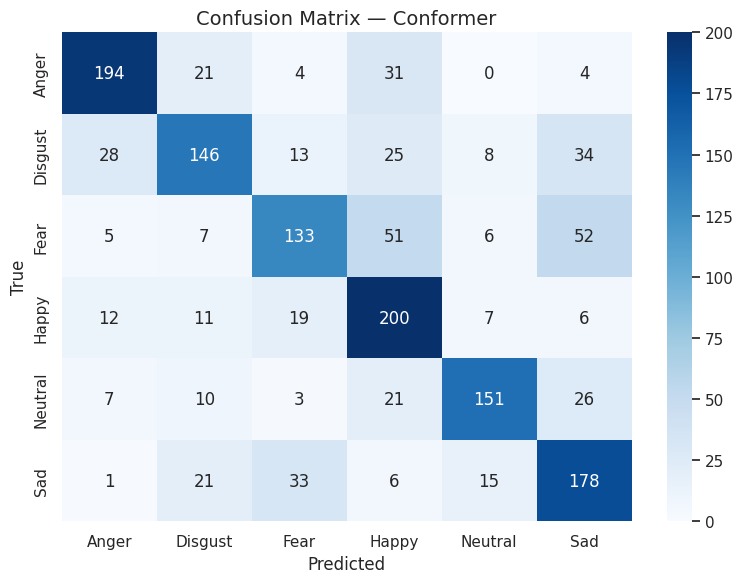

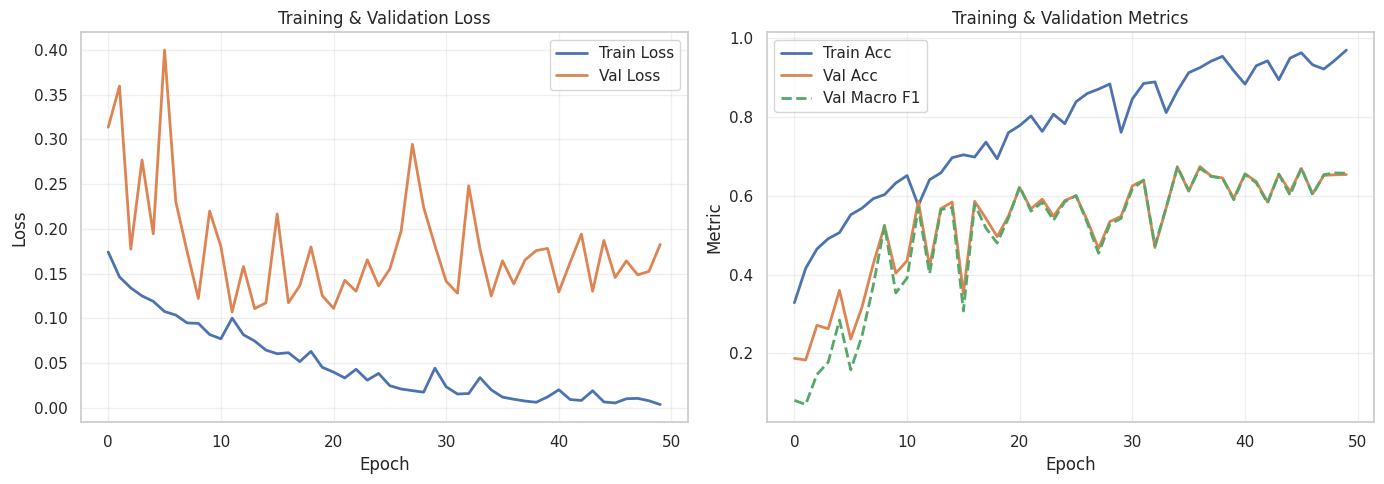

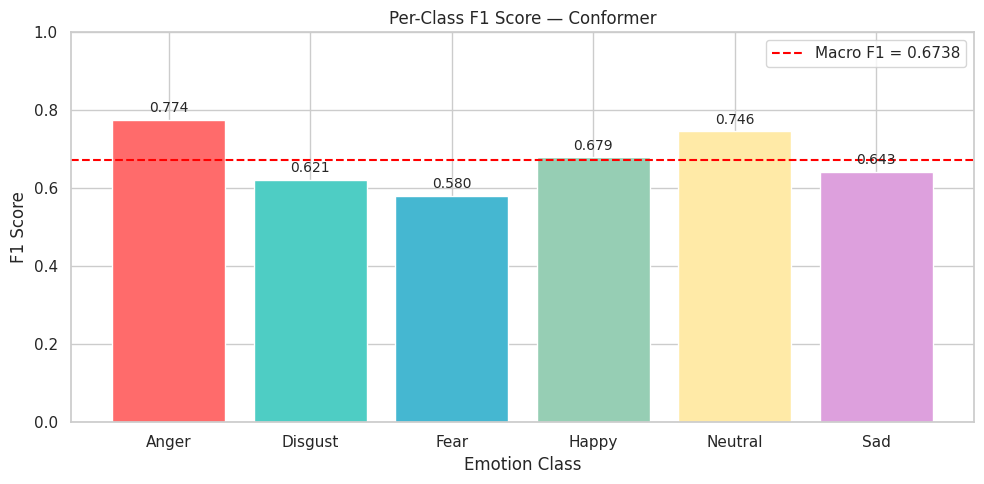

In [10]:
# =====================
# 评估代码（训练后运行）
# =====================
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 加载最佳模型
best_model = tf.keras.models.load_model(
    "../best_conformer.h5",
    custom_objects={"FocalLoss": FocalLoss}
)

# 预测
y_pred_proba = best_model.predict(Xte, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 分类报告
print("=" * 60)
print("Classification Report - Conformer")
print("=" * 60)
print(classification_report(yte_emo, y_pred, target_names=le_emo.classes_, digits=4))

# 计算各项指标
macro_f1 = f1_score(yte_emo, y_pred, average="macro")
weighted_f1 = f1_score(yte_emo, y_pred, average="weighted")
accuracy = np.mean(y_pred == yte_emo)

print(f"\nSummary:")
print(f"  Accuracy:    {accuracy:.4f}")
print(f"  Macro F1:    {macro_f1:.4f}")
print(f"  Weighted F1: {weighted_f1:.4f}")

# 混淆矩阵
cm = confusion_matrix(yte_emo, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=le_emo.classes_, 
    yticklabels=le_emo.classes_
)
plt.title("Confusion Matrix — Conformer", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.tight_layout()
plt.savefig("confusion_matrix_conformer.png", dpi=150)
plt.show()

# 绘制训练曲线
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss 曲线
axes[0].plot(hist.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(hist.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy 曲线
axes[1].plot(hist.history['accuracy'], label='Train Acc', linewidth=2)
axes[1].plot(hist.history['val_accuracy'], label='Val Acc', linewidth=2)
if 'val_macro_f1' in hist.history:
    axes[1].plot(hist.history['val_macro_f1'], label='Val Macro F1', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Metric')
axes[1].set_title('Training & Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves_conformer.png", dpi=150)
plt.show()

# 各类别 F1 柱状图
from sklearn.metrics import f1_score
class_f1 = f1_score(yte_emo, y_pred, average=None)
plt.figure(figsize=(10, 5))
bars = plt.bar(le_emo.classes_, class_f1, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'])
plt.axhline(y=macro_f1, color='red', linestyle='--', label=f'Macro F1 = {macro_f1:.4f}')
plt.xlabel('Emotion Class')
plt.ylabel('F1 Score')
plt.title('Per-Class F1 Score — Conformer')
plt.legend()
plt.ylim(0, 1)
for bar, f1 in zip(bars, class_f1):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{f1:.3f}', ha='center', fontsize=10)
plt.tight_layout()
plt.savefig("class_f1_conformer.png", dpi=150)
plt.show()
